In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# Voting classifiers
Voting classifiers trains a group of classifiers and takes a majority vote of all the classifiers predictions. The majority vote can be either a hard vote or a soft vote. A soft vote is the weighted average of the probablilites, while a hard vote is just a mode.

<AxesSubplot:>

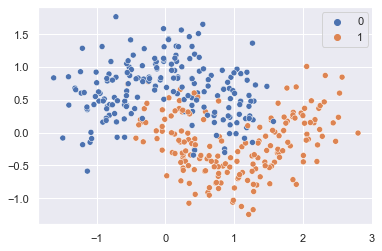

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

lr = LogisticRegression()
svc = SVC()
rf_clf = RandomForestClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf_clf), ('svc', svc)],
    voting='hard', # can be 'soft' if all the classifiers have 'predict_proba' method
    n_jobs=-1)


for clf in (lr, rf_clf, svc, voting_clf):
    clf.fit(X_train, y_train)
    print(clf.__class__.__name__, clf.score(X_test, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## Bagging
Bagging is similar to a VotingClassifier, but instead of training different estimators on one training data set like a VotingClassifier, bagging uses one estimator (a DecisionTree) on different sub-samples of the training data set. If sub-sampling is done with replacement, then it is called bagging, whereas when sub-sampling is done without replacement it is called pasting. 

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(min_samples_leaf=5), # hyperparameters can be set here
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True, # if true, sample with replacement
    random_state=42, n_jobs=-1
)
bag_clf.fit(X_train, y_train).score(X_test, y_test)

0.896

<AxesSubplot:>

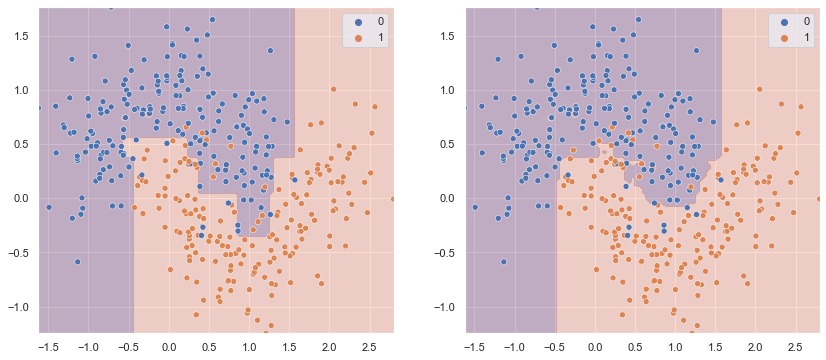

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# left plot: decision tree
dt_clf = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)
x1 = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
x2 = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
xx, yy = np.meshgrid(x1, x2)
X_new = np.c_[xx.ravel(), yy.ravel()]
z = dt_clf.predict(X_new).reshape(xx.shape)
ax[0].contourf(xx, yy, z, levels=1, alpha=0.3)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax[0])

# right plot: bagging clf
z1 = bag_clf.predict(X_new).reshape(xx.shape)
ax[1].contourf(xx, yy, z1, levels=1, alpha=0.3)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax[1])

## Random Forests
Bagging provides a degree of randomness by sub-sampling the training dataset. Bagging also provides a way to sub-sample the features, by way of 'max_features' and 'bootstrap_features' hyperparameters. RandomForests do this automatically. 
- sampling both training instances and features is called random pathces,
- sampling only features, and keeping all the instances is called random subspaces.

BaggingClassifier can be provided with any 'base_estimator', whereas decision tree classifier is the default for RandomForestClassifer. Apart from that, RadnomForestClassifier has all the hyperparameters of a BaggingClassifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=500,
    random_state=42, n_jobs=-1,
    min_samples_leaf=5
)
rf_clf.fit(X_train, y_train).score(X_test, y_test)

0.912

In [20]:
0.912 / 0.896

1.0178571428571428

**Notice** that random forest gives ~1.7% improvement over Bagging, just by uncorrelating the grown trees by way of random sampling of the features

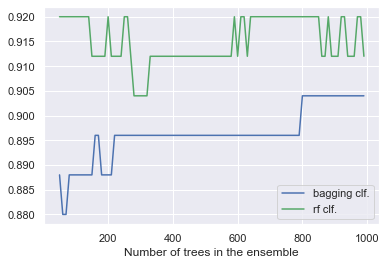

In [22]:
# random forest vs. bagging
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(min_samples_leaf=5),
    max_samples=1.0,
    bootstrap=True,
    random_state=42, n_jobs=-1
)
rf_clf = RandomForestClassifier(
    random_state=42, n_jobs=-1,
    min_samples_leaf=5
)
bag_scores, rf_scores = [], []
n_estimators = range(50, 1000, 10)
for i in n_estimators:
    bag_clf.set_params(n_estimators=i)
    rf_clf.set_params(n_estimators=i)
    
    bag_clf.fit(X_train, y_train)
    rf_clf.fit(X_train, y_train)
    
    bag_scores.append(bag_clf.score(X_test, y_test))
    rf_scores.append(rf_clf.score(X_test, y_test))

plt.plot(n_estimators, bag_scores, 'b-', label='bagging clf.')
plt.plot(n_estimators, rf_scores, 'g-', label='rf clf.')
plt.xlabel('Number of trees in the ensemble')
plt.ylabel('accuracy score')
plt.legend();

In [23]:
np.mean(rf_scores) / np.mean(bag_scores)

1.0211406558301237

On an average, random forest provides ~2.1% improvement over bagging.

## Featrue improtance
Decision trees, bagging & random forests provide feature importance based on how much the tree nodes that use a feature reduce node impurtiy on average.

(-0.5, 27.5, 27.5, -0.5)

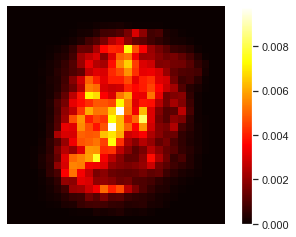

In [27]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib as mpl 

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(mnist.data, mnist.target)
print(accuracy_score(mnist.target, rf_clf.predict(mnist.data)))
plt.imshow(rf_clf.feature_importances_.reshape(28, 28), 
           cmap=mpl.cm.hot, interpolation='nearest')
plt.colorbar()
plt.axis('off')